# Homework 4

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

In [35]:
def get_tail_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # find real tail
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    tail = image[y:y+h, x:x+w]
    tail_mask = mask[y:y+h, x:x+w]

    # normalize photos
    tail_contours, _ = cv2.findContours(tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tail_contour = max(tail_contours, key=cv2.contourArea)
    (x, y), (MA, ma), angle = cv2.fitEllipse(tail_contour)
    rows, cols, _ = tail.shape

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_tail = cv2.warpAffine(tail, M, (cols, rows))
    rotated_mask = cv2.warpAffine(tail_mask, M, (cols, rows))
    
    # Обрезка повернутого изображения по bounding box самого большого контура
    rotated_contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rotated_contour = max(rotated_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(rotated_contour)
    cropped_tail = rotated_tail[y:y+h, x:x+w]
    cropped_mask = rotated_mask[y:y+h, x:x+w]
    
    normalized_tail = cv2.resize(cropped_tail, (128, 128))
    normalized_mask = cv2.resize(cropped_mask, (128, 128))
    return tail, tail_mask, normalized_tail, normalized_mask
    

In [41]:
def iou(real, pred):
    real = real.flatten()
    pred = pred.flatten()
    assert len(real) == len(pred)
    intersection = np.logical_and(real, pred)
    union = np.logical_or(real, pred)
    return np.sum(intersection) / np.sum(union)

In [80]:
def process_photos(image_path, mask_path):
    tail, tail_mask, normalized_tail, normalized_mask = get_tail_mask(image_path, mask_path)
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes[0, 0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    axes[0, 1].imshow(tail_mask, cmap='gray')
    axes[1, 0].imshow(cv2.cvtColor(tail, cv2.COLOR_BGR2RGB))
    axes[1, 1].imshow(cv2.cvtColor(normalized_tail, cv2.COLOR_BGR2RGB))

    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    return iou(cv2.resize(tail_mask, (128, 128)), normalized_mask)
    

np.float64(0.43095067336042714)

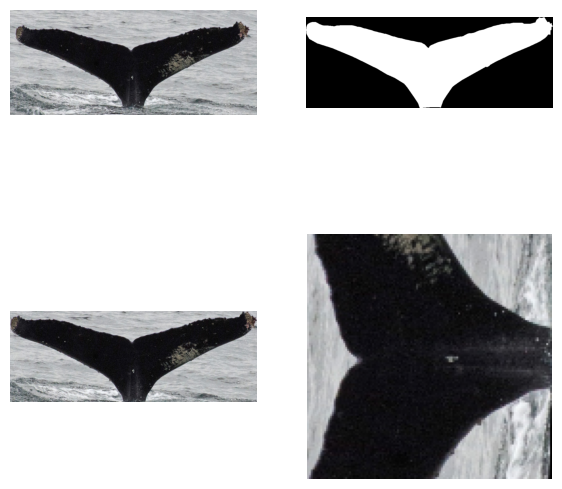

In [81]:
process_photos('whale_tail/images/test_image_00.jpg', 'whale_tail/ground_truth/test_image_00.png')

np.float64(0.5444276509426458)

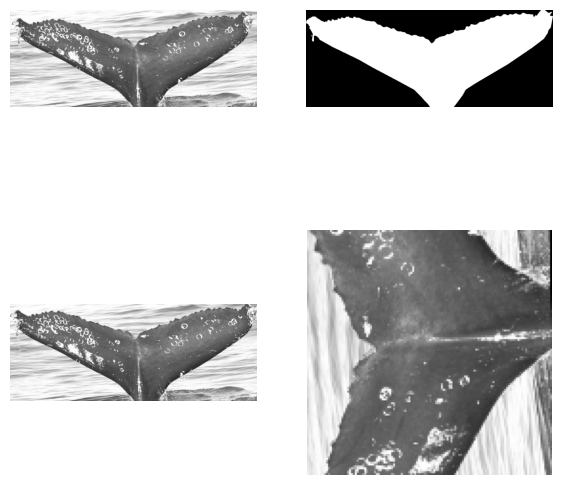

In [82]:
process_photos('whale_tail/images/test_image_01.jpg', 'whale_tail/ground_truth/test_image_01.png')

np.float64(0.46476025418833045)

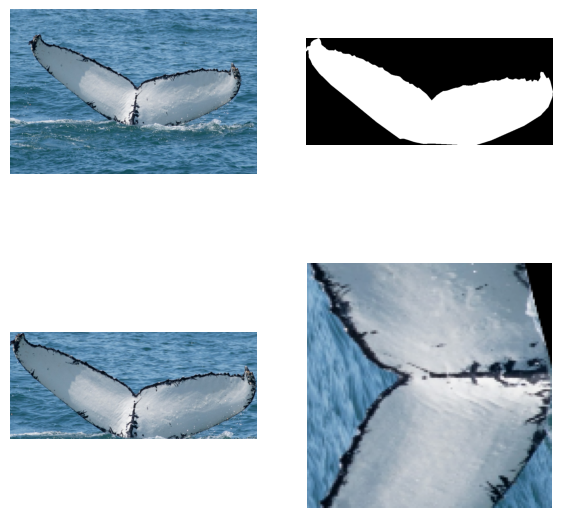

In [83]:
process_photos('whale_tail/images/test_image_02.jpg', 'whale_tail/ground_truth/test_image_02.png')

np.float64(0.4292800731022779)

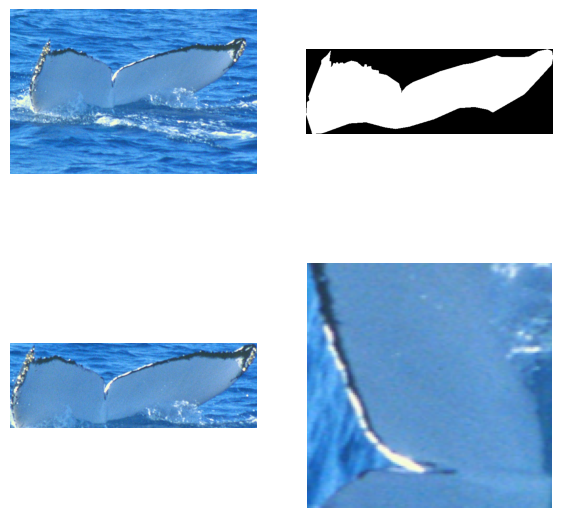

In [84]:
process_photos('whale_tail/images/test_image_03.jpg', 'whale_tail/ground_truth/test_image_03.png')

np.float64(0.4442186547449705)

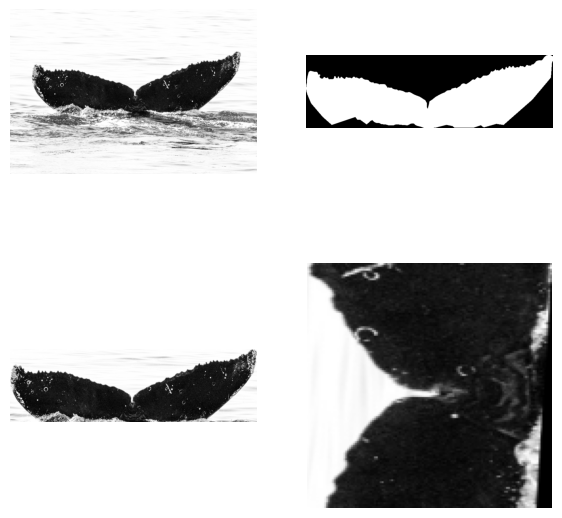

In [85]:
process_photos('whale_tail/images/test_image_08.jpg', 'whale_tail/ground_truth/test_image_08.png')

np.float64(0.4707908927501498)

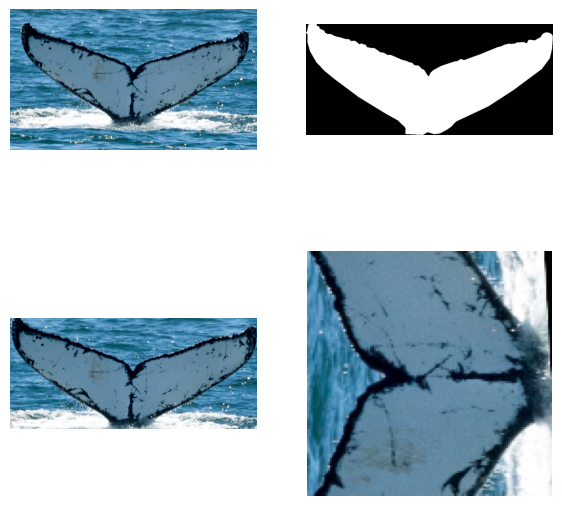

In [86]:
process_photos('whale_tail/images/test_image_10.jpg', 'whale_tail/ground_truth/test_image_10.png')

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [147]:
from skimage.feature import hog

In [148]:
def get_hog(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_fd = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
    return hog_fd

In [149]:
def find_eye(image, eye_hog_fd, template_size):
    best_loc = (0, 0)
    best_score = -1

    image_hog_fd = get_hog(image)
    image_hog = image_hog_fd.reshape(image.shape[0] // 8 - 1, image.shape[1] // 8 - 1, -1)
    template_hog = eye_hog_fd.reshape(template_size[1] // 8 - 1, template_size[0] // 8 - 1, -1)
    
    results = []
    for channel in range(template_hog.shape[2]):
        template_channel = template_hog[:, :, channel]
        image_channel = image_hog[:, :, channel]

        template_channel = cv2.normalize(template_channel, None, 0, 1, cv2.NORM_MINMAX)
        image_channel = cv2.normalize(image_channel, None, 0, 1, cv2.NORM_MINMAX)

        template_channel = template_channel.astype(np.float32)
        image_channel = image_channel.astype(np.float32)

        result = cv2.matchTemplate(image_channel, template_channel, cv2.TM_CCOEFF_NORMED)
        results.append(result)

    final_result = np.mean(results, axis=0)
    _, max_val, _, max_loc = cv2.minMaxLoc(final_result)

    best_loc = (max_loc[0] * 8, max_loc[1] * 8)
    best_score = max_val

    return best_loc, best_score


In [154]:
def find_eye_by_scales(image_path, scales=[0.8, 0.9, 1.0, 1.1, 1.2]):
    eye = cv2.imread('hog/eye.png')
    eye_fd = get_hog(eye)

    image = cv2.imread(image_path)

    best_loc = (0, 0)
    best_score = -1

    for scale in scales:
        scaled_image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)), interpolation=cv2.INTER_LINEAR)
        loc, score = find_eye(scaled_image, eye_fd, (eye.shape[1], eye.shape[0]))
        loc = (int(loc[0] / scale), int(loc[1] / scale))

        if score > best_score:
            best_score = score
            best_loc = loc


    top_left = best_loc
    bottom_right = (best_loc[0] + eye.shape[1], best_loc[1] + eye.shape[0])
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    print(f'Score = {best_score}')



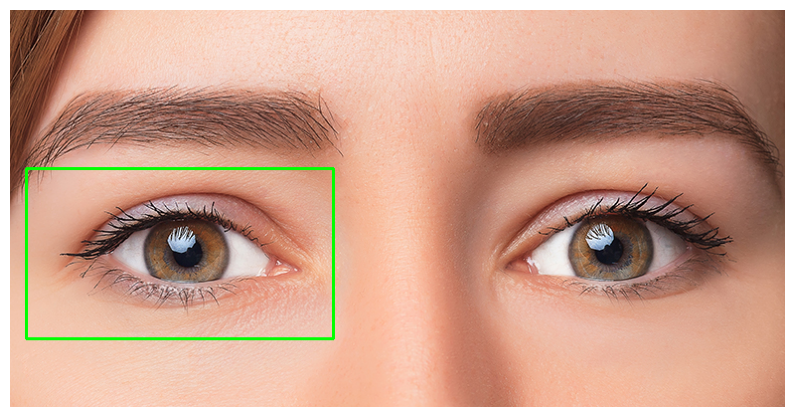

Score = 0.799710750579834


In [155]:
find_eye_by_scales('hog/eyes.jpg')

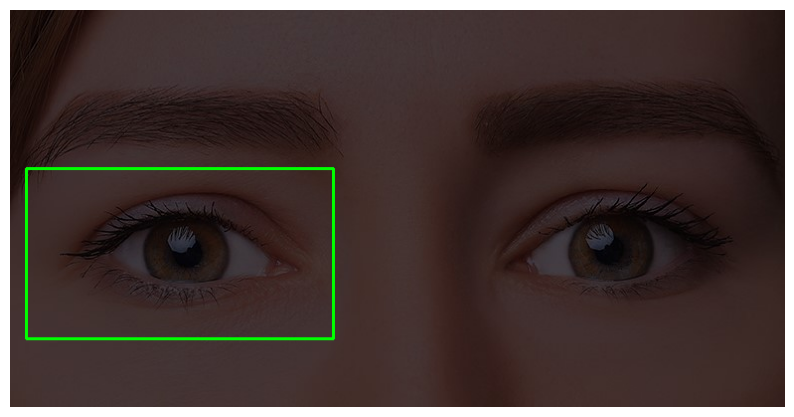

Score = 0.5076101422309875


In [156]:
find_eye_by_scales('hog/eyes_dark.jpg')

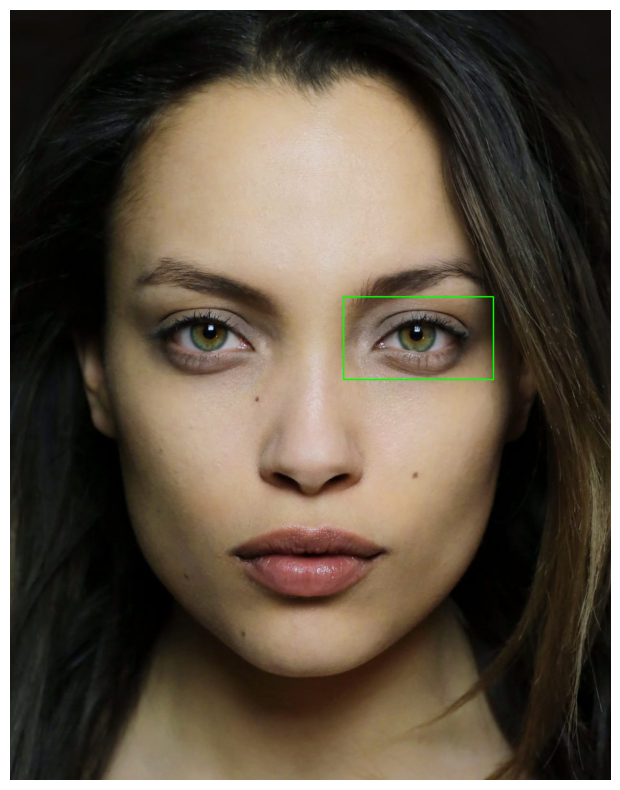

Score = 0.19206023216247559


In [157]:
find_eye_by_scales('hog/woman.jpg')